# I. Algorithm 


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting

In [45]:
class Perceptron(object):
    weights = None
    bias = None

    def activate(self, preactivation):
        if preactivation > 0:
            return 1
        else:
            return -1

    def predict(self, signal):

        preactivation = signal @ self.weights + self.bias
        return self.activate(preactivation)
    
    def update(self, actual, predicted, signal):
        '''
        Updates the weights of Perceptron
        '''
        self.weights = self.weights - 1/2 * (predicted - actual) * signal.T
        self.bias = self.bias - 1/2 * (predicted - actual)

    def cost_function(self, actual, predicted):
        '''
        Returns 1 if actual = predicted, 0 otherwise
        '''
        return(actual != predicted)
    def train(self, X, y, epochs=20):
        '''
        Trains the perceptron over the given dataset (X, y) for a specified number of epochs.
        '''
        # Initialize weights and bias if not already set
        if self.weights is None:
            self.weights = np.zeros(X.shape[1])
        if self.bias is None:
            self.bias = 0

        for epoch in range(epochs):
            total_errors = 0
            # Going through the training data
            for i in range(len(X)):
                signal = X[i]
                actual = y[i]
                predicted = self.predict(signal)
                # Updating weights
                if self.cost_function(actual, predicted):
                    self.update(actual, predicted, signal)
                    total_errors += 1
            if epoch % 5 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Misclassifications: {total_errors}")
            if total_errors <= len(X)/20: # Stop training when less than 5% error
                print("Training converged.")
                break

# II. Application to Data Set

In [11]:
coaster_data = pd.read_csv("../coaster_db.csv")

In [34]:
coaster_data.tail(5)

,coaster_name,Length,Speed,Location,Status,Opening date,Type,Manufacturer,Height restriction,Model,...,speed1,speed2,speed1_value,speed1_unit,speed_mph,height_value,height_unit,height_ft,Inversions_clean,Gforce_clean
1082,American Dreier Looping,"3,444 ft (1,050 m)",53 mph (85 km/h),Other,NaN,NaN,Steel,Anton Schwarzkopf,55 in (140 cm),NaN,...,53 mph,85 km/h,53.0,mph,53.0,111.0,ft,NaN,3,4.7
1083,Pantheon (roller coaster),"3,328 ft (1,014 m)",73 mph (117 km/h),Busch Gardens Williamsburg,Under construction,2022,Steel – Launched,Intamin,NaN,Blitz Coaster,...,73 mph,117 km/h,73.0,mph,73.0,178.0,ft,NaN,2,NaN
1084,Tron Lightcycle Power Run,"3,169.3 ft (966.0 m)",59.3[1] mph (95.4 km/h),Other,NaN,"June 16, 2016",Steel – Launched,Vekoma,4[2] ft (122 cm),Motorbike roller coaster,...,59.3 mph,95.4 km/h,59.3,mph,59.3,78.1,ft,NaN,0,4.0
1085,Tumbili,770 ft (230 m),34 mph (55 km/h),Kings Dominion,Under construction,NaN,Steel – 4th Dimension – Wing Coaster,S&S – Sansei Technologies,NaN,4D Free Spin,...,34 mph,55 km/h,34.0,mph,34.0,112.0,ft,NaN,0,NaN
1086,Wonder Woman Flight of Courage,"3,300 ft (1,000 m)",58 mph (93 km/h),Six Flags Magic Mountain,Under construction,2022,Steel – Single-rail,Rocky Mountain Construction,NaN,Raptor – Custom,...,58 mph,93 km/h,58.0,mph,58.0,131.0,ft,NaN,3,NaN


In [37]:
coaster_data.loc[coaster_data['height_unit'] == 'ft', 'height_ft'] = coaster_data['height_value']


cleaned_data = coaster_data[['height_ft','speed_mph','Gforce_clean','Type']]

# Classifying any wooden roller coaster as 1 and steel roller coaster as -1
cleaned_data['Material'] = np.where(
    ~cleaned_data['Type'].str.contains('Steel', case=False, na=False), 
    1, 
    np.where(
        cleaned_data['Type'].str.contains('Steel', case=False, na=False),
        -1,
        np.nan  
    )
)

# Dropping NaN data 
cleaned_data.dropna(inplace = True)

# Separate data by Material
wood = cleaned_data[cleaned_data['Material'] == 1]
steel = cleaned_data[cleaned_data['Material'] == -1]

/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_33327/4265236236.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Material'] = np.where(
/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_33327/4265236236.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.dropna(inplace = True)


In [38]:
cleaned_data.shape # 350 roller coasters in our data 


(350, 5)

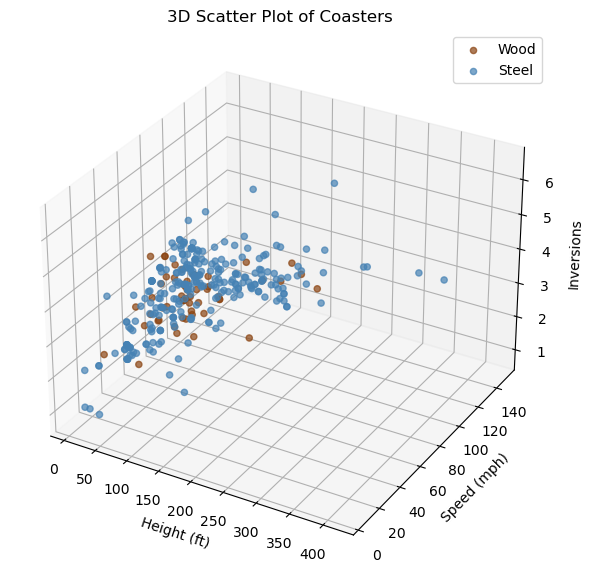

In [ ]:
# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot wood coasters
ax.scatter(
    wood['height_ft'], wood['speed_mph'], wood['Gforce_clean'],
    c='saddlebrown', label='Wood', alpha=0.7
)

# Plot steel coasters
ax.scatter(
    steel['height_ft'], steel['speed_mph'], steel['Gforce_clean'],
    c='steelblue', label='Steel', alpha=0.7
)

# Set axis labels
ax.set_xlabel('Height (ft)')
ax.set_ylabel('Speed (mph)')
ax.set_zlabel('Gforce')

# Title and legend
ax.set_title('3D Scatter Plot of Coasters')
ax.legend()

plt.show()

In [47]:
X = cleaned_data[['height_ft','speed_mph','Gforce_clean']].to_numpy()
y = cleaned_data['Material'].to_numpy()

p = Perceptron()
p.train(X,y, epochs = 300)

Epoch 1/300, Misclassifications: 83
Epoch 6/300, Misclassifications: 85
Epoch 11/300, Misclassifications: 81
Epoch 16/300, Misclassifications: 78
Epoch 21/300, Misclassifications: 79
Epoch 26/300, Misclassifications: 80
Epoch 31/300, Misclassifications: 83
Epoch 36/300, Misclassifications: 85
Epoch 41/300, Misclassifications: 81
Epoch 46/300, Misclassifications: 80
Epoch 51/300, Misclassifications: 81
Epoch 56/300, Misclassifications: 78
Epoch 61/300, Misclassifications: 83
Epoch 66/300, Misclassifications: 82
Epoch 71/300, Misclassifications: 81
Epoch 76/300, Misclassifications: 77
Epoch 81/300, Misclassifications: 77
Epoch 86/300, Misclassifications: 75
Epoch 91/300, Misclassifications: 77
Epoch 96/300, Misclassifications: 77
Epoch 101/300, Misclassifications: 75
Epoch 106/300, Misclassifications: 81
Epoch 111/300, Misclassifications: 76
Epoch 116/300, Misclassifications: 78
Epoch 121/300, Misclassifications: 78
Epoch 126/300, Misclassifications: 78
Epoch 131/300, Misclassifications: